In [1]:
import os
import torch
import numpy as np
import pandas as pd
from mediapipe import solutions

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from video_converter import Video2DataFrame
from custom_pose_landmarks import CustomPoseLandmark

import math as m

from utils import landmark2array

In [2]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

# Custom pose landmark names and their connections
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP'],}

# MediaPipe solutions
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose

custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)
connections = list(custom_pose.get_connections())

conv = Video2DataFrame(mp_pose, mp_drawing, custom_pose)

In [3]:
def plot_skeleton(skeleton_coordinates, connections, t=None, elev=0, azim=0, roll=0):
    """
    
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if t:
        S = np.arange(-t, t, 0.1)
        plt.plot(S, np.zeros_like(S))
        plt.plot(np.zeros_like(S), S)

    for joint in skeleton_coordinates:
        x, y, z = joint
        ax.scatter(x, y, z, c='r', marker='o')

    for connection in connections:
        joint_1 = skeleton_coordinates[connection[0]]
        joint_2 = skeleton_coordinates[connection[1]]
        ax.plot(
            [joint_1[0], joint_2[0]],
            [joint_1[1], joint_2[1]],
            [joint_1[2], joint_2[2]],
            c='b'
        )

    # Set axes names
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.grid(True)
    ax.axis('equal')

    ax.view_init(elev=elev, azim=azim, roll=roll)

    plt.show()

In [4]:
class PoseCanonicalForm():
    """
    
    """
    def __init__(self, data, default_position=np.array([1, 0, 1]), default_point=np.zeros(shape=(3,)), default_length=0.25):      
        # Initialize 
        self.data = data
        self.default_position = default_position
        self.default_point = default_point
        self.default_length = default_length

        # Extract the coordinates of left and right hips for rotation and scaling
        left_hip = self.data.filter(regex='^LeftHip').values[0]
        right_hip = self.data.filter(regex='^RightHip').values[0]

        # Determine the hips vector
        self.hips_vector = left_hip - right_hip

        
    def rotation_procedure(self):
        """
        
        """
        # Calculate the dot product of default position vector and hips vector
        dot_product = np.dot(self.default_position, self.hips_vector)

        # Calculate the cosine of default position vector and hips vector
        cos_alpha = dot_product / (
            np.linalg.norm(self.default_position) * np.linalg.norm(self.hips_vector)
            )

        # Protection against numerical errors - cosine value should be in the range [-1, 1]
        bounded_cos_alpha = min(1, max(-1, cos_alpha))

        # Calculate alpha using arccosine function
        alpha = np.arccos(bounded_cos_alpha)

        return alpha
        
    
    def rotate(self, coordinates):
        """
        
        """
        alpha = self.rotation_procedure()

        rotation_matrix = np.array(
            [
                [m.cos(alpha), 0, m.sin(alpha)],
                [0, 1, 0],
                [-m.sin(alpha), 0, m.cos(alpha)],
            ]
        )

        return np.dot(rotation_matrix, coordinates)


    def translation_procedure(self):
        """
        
        """
        # Extract the coordinates of pelvis
        pelvis = self.data.filter(regex='^Pelvis').values[0]

        # Determine a vector anchored at the origin and pelvis point
        vector = self.default_point - pelvis

        return vector


    def translate(self, coordinates):
        """
        
        """
        vector = self.translation_procedure()

        return vector + coordinates


    def scaling_procedure(self):
        """
        
        """
        # Calculate the length of hips vector
        hip_length = np.linalg.norm(self.hips_vector)

        # Calculate the scale factor
        scale_factor = self.default_length / hip_length

        return scale_factor
    

    def scale(self, coordinates):
        """
        
        """
        scale_factor = self.scaling_procedure()

        return scale_factor * coordinates
    

    def transform(self, coordinates):
        """
        
        """
        
        transformed = self.scale(self.translate(self.rotate(coordinates)))

        return transformed

In [5]:
def calculate_angles(vector):
    x_angle = np.arctan2(vector[1], vector[0])
    y_angle = np.arctan2(vector[2], vector[1])
    z_angle = np.arctan2(vector[0], vector[2])

    return x_angle, y_angle, z_angle

def calculate_angle(vector):
    return np.arctan2(vector[2], vector[0])

def rotate(alpha, coordinates):

    rotation_matrix = np.array(
        [
            [np.cos(alpha), 0, np.sin(alpha)],
            [0, 1, 0],
            [- np.sin(alpha), 0, np.cos(alpha)],
        ]
    )

    return np.dot(rotation_matrix, coordinates.T).T

In [6]:
def get_matrix(alpha, beta, gamma):

    # 
    rotation_x = np.array(
        [
            [1, 0, 0],
            [0, np.cos(alpha), - np.sin(alpha)],
            [0, np.sin(alpha), np.cos(alpha)]
        ]
    )

    #
    rotation_y = np.array(
        [
            [np.cos(beta), 0, np.sin(beta)],
            [0, 1, 0],
            [- np.sin(beta), 0, np.cos(beta)]
        ]
    )

    #
    rotation_z = np.array(
        [
            [np.cos(gamma), - np.sin(gamma), 0],
            [np.sin(gamma), np.cos(gamma), 0],
            [0, 0, 1]
        ]
    )

    #
    global_matrix = rotation_x.dot(rotation_y).dot(rotation_z)

    return global_matrix

In [7]:
def calc_angle(vector_1, vector_2):
    dot_product = np.dot(vector_1, vector_2)

    cos_alpha = dot_product / (
        np.linalg.norm(vector_1) * np.linalg.norm(vector_2)
    )

    bounded_cos_alpha = min(1, max(-1, cos_alpha))

    return np.arccos(bounded_cos_alpha)

In [8]:
video_path = '../data/raw/squat/007_05_01_01_152_1_L.MP4'
dataframe = conv.get_dataframe(source=video_path, detection=0.9, tracking=0.9)

data = dataframe.copy()
index = 10

# Get column names list
columns = data.columns
# Take first row as default position
data = pd.DataFrame(data.iloc[index]).T

can = PoseCanonicalForm(data, default_position = np.array([1, 0, 0]), default_length=1)

# Create a list to store the coordinates of each point (landmarks)
coordinates = []

for i in range(9, len(columns), 3):
    # Extract three consecutive column names and their values
    column_names = list(columns[i:i+3])
    name = column_names[0][:-1]

    values = data[column_names].values[0]
    values = can.scale(can.translate(values))
    coordinates.append(values)

coordinates = coordinates = np.array(coordinates, dtype=float)

Converting 007_05_01_01_152_1_L file to dataframe...


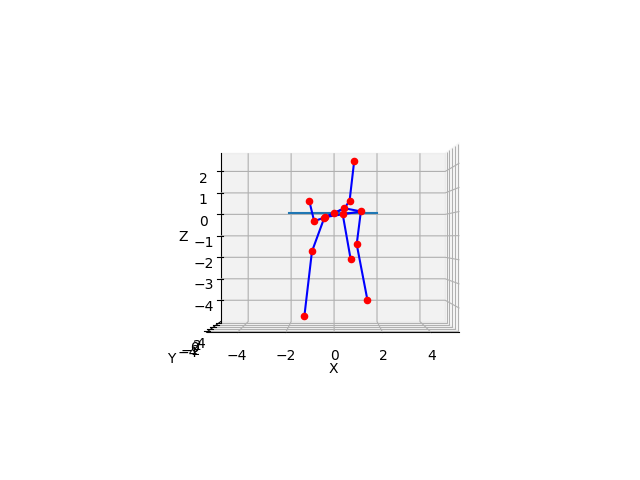

In [21]:
plot_skeleton(coordinates, connections, t=2, elev=0, azim=-90, roll=0)

In [38]:
def kth_root(x,k):
    if k % 2 != 0:
        res = np.power(np.abs(x),1./k)
        return res*np.sign(x)
    else:
        return np.power(np.abs(x),1./k)

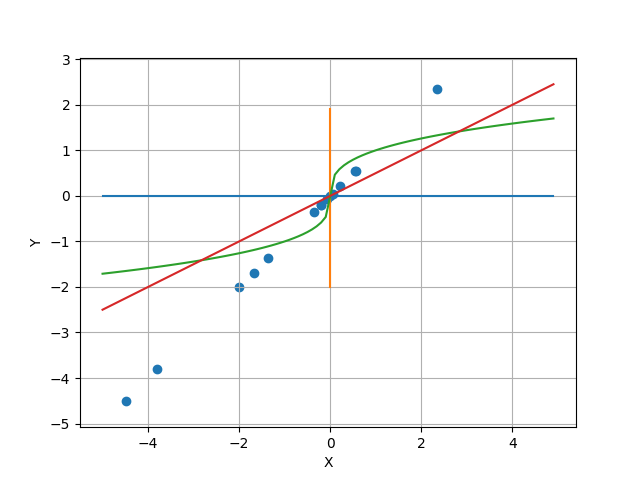

In [57]:
z = coordinates[:, 2]
z_prime = kth_root(z, 3)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(-5, 5, 0.1), np.zeros_like(np.arange(-5, 5, 0.1)))
plt.plot(np.zeros_like(np.arange(-2, 2, 0.1)), np.arange(-2, 2, 0.1))

plt.scatter(z, z);

plt.plot(np.arange(-5, 5, 0.1), kth_root(np.arange(-5, 5, 0.1), 3));

plt.plot(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1) / 2);

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.grid(True)
ax.axis('equal')

plt.show()

C:\Users\nemet\AppData\Local\Temp\ipykernel_16644\1550341031.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


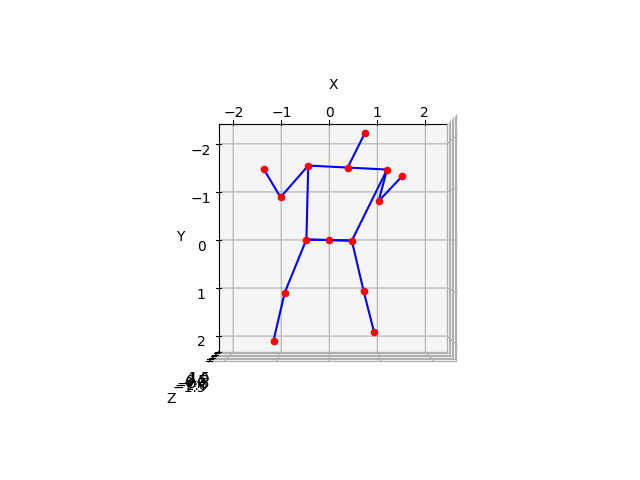

In [65]:
z = coordinates[:, 2]
z_prime = kth_root(z, 3)

z_prime = z / 10

coordinates_prime = np.column_stack((coordinates[:, :2], z_prime))

plot_skeleton(coordinates_prime, connections, elev=-90, azim=-90, roll=0)

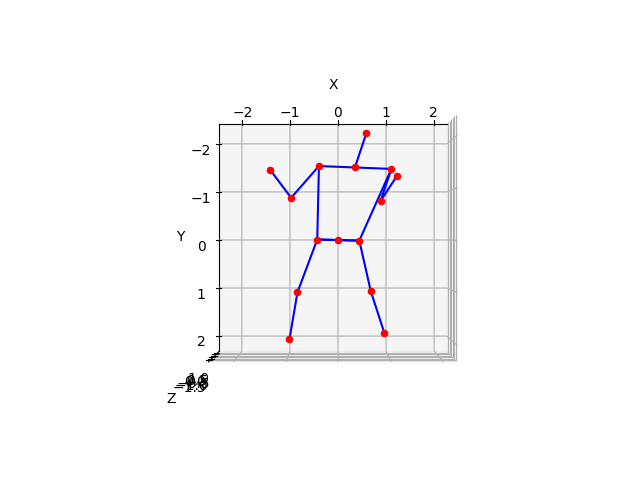

In [66]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values[0]
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values[0]
hip_vector = left_hip - right_hip

angle = np.arctan2(hip_vector[2], hip_vector[0])

rotation_matrix = np.array(
    [
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [- np.sin(angle), 0, np.cos(angle)],
    ]
)


z = coordinates[:, 2]
z_prime = z / 10

coordinates_prime = np.column_stack((coordinates[:, :2], z_prime))
coordinates_prime = np.dot(rotation_matrix, coordinates_prime.T).T

plot_skeleton(coordinates_prime, connections, elev=-90, azim=-90, roll=0)

In [18]:
left_wrist = data[['LeftWristX', 'LeftWristY', 'LeftWristZ']].values[0]
right_wrist = data[['RightWristX', 'RightWristY', 'RightWristZ']].values[0]

pose_vector = left_wrist - right_wrist
pose_vector

alpha = np.arctan2(pose_vector[1], pose_vector[2])
beta = np.arctan2(pose_vector[2], pose_vector[0])
gamma = np.arctan2(pose_vector[0], pose_vector[1])

print(np.rad2deg((alpha, beta, gamma)))

[11.30241329 14.35428831 87.07208431]


In [20]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values[0]
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values[0]
hip_vector = left_hip - right_hip
print(hip_vector)

alpha = np.arctan2(hip_vector[1], hip_vector[2])
beta = np.arctan2(hip_vector[2], hip_vector[0])
gamma = np.arctan2(hip_vector[0], hip_vector[1])
print(np.rad2deg((alpha, beta, gamma)))

matrix = get_matrix(0, beta, 0)
print(matrix)

[0.15121003985404968 0.003610968589782715 0.06987036392092705]
[ 2.95846972 24.80047354 88.63200919]
[[ 0.90777401  0.          0.41945958]
 [ 0.          1.          0.        ]
 [-0.41945958  0.          0.90777401]]


In [27]:
import open3d as o3d
import numpy as np

# RightHip 8
# LeftHip 7

# LeftKnee 9
# RightKnee 10

# SCALING
left_hip = coordinates[7]
right_hip = coordinates[8]

left_knee = coordinates[9]
right_knee = coordinates[10]

left_thigh = left_hip - left_knee
right_thigh = right_hip - right_knee
scalar = np.mean((np.linalg.norm(left_thigh), np.linalg.norm(right_thigh)))

z = coordinates[:, 2]
z_prime = z / scalar

coordinates_prime = np.column_stack((coordinates[:, :2], z_prime))


# ROTATION
left_hip = coordinates_prime[7]
right_hip = coordinates_prime[8]
hip_vector = left_hip - right_hip

alpha = np.arctan2(hip_vector[1], hip_vector[2])
beta = np.arctan2(hip_vector[2], hip_vector[0])
gamma = np.arctan2(hip_vector[0], hip_vector[1])
print((alpha, beta, gamma))
print(np.rad2deg((alpha, beta, gamma)))

matrix = get_matrix(0, 0, 0)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coordinates_prime)

pcd.rotate(matrix)

# o3d.visualization.draw_geometries([pcd])

coordinates_prime = np.asarray(pcd.points)

(0.058024005046484, 0.39003867159377387, 1.5469203830407179)
[ 3.3245306  22.34756973 88.63200919]


In [29]:
z = coordinates[:, 2]
z

array([-2.00676326,  0.05129667, -0.19674634, -1.37267755, -1.68517864,
       -3.79447234, -4.49434045,  0.20968053, -0.20968053,  0.5563137 ,
       -0.34832906,  2.34894153,  0.54692443, -0.07272483,  0.        ])

In [30]:
z.mean()

-0.6978504096114287

In [31]:
z.std()

1.6817726750338557

In [33]:
(z - z.mean()) / scalar

array([-1.16451734,  0.66650332,  0.4458237 , -0.60038214, -0.87840901,
       -2.75501148, -3.37767215,  0.80741473,  0.43431638,  1.11580833,
        0.31096316,  2.71067859,  1.10745485,  0.55616352,  0.62086555])

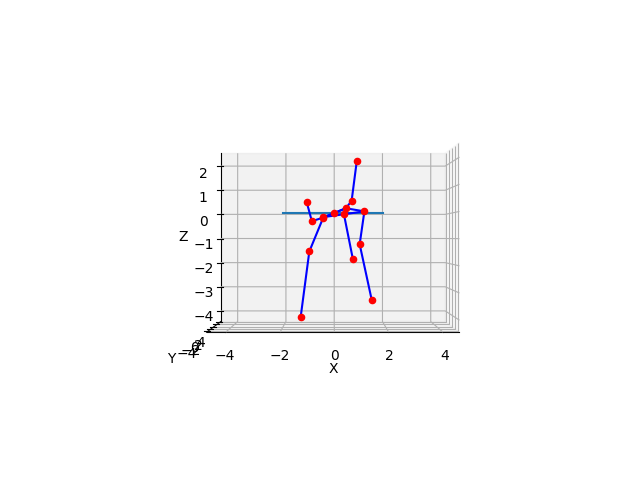

In [28]:
plot_skeleton(coordinates_prime, connections, t=2, elev=0, azim=-90, roll=0)

In [40]:
import open3d as o3d
import numpy as np

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coordinates)

pcd.rotate(matrix)

# o3d.visualization.draw_geometries([pcd])

coordinates_prime = np.asarray(pcd.points)

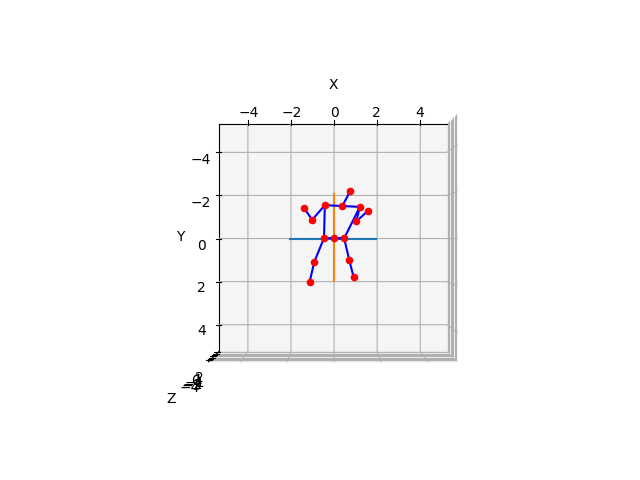

In [41]:
plot_skeleton(coordinates_prime, connections, t=2, elev=-90, azim=-90, roll=0)

In [117]:
coordinates_prime = np.dot(matrix, coordinates.T).T
coordinates_prime

array([[-1.88943151e+00, -1.91020908e-01, -2.32735316e+00],
       [ 1.42236702e-01,  5.00566502e-01, -1.74686516e+00],
       [-1.35811437e-01, -9.73456249e-01, -1.20772360e+00],
       [-1.31330557e+00,  5.96357692e-01, -1.17036022e+00],
       [-1.66397718e+00, -1.22319391e+00, -4.83093843e-01],
       [-3.69896050e+00,  8.27482997e-01, -1.92688416e+00],
       [-4.45054981e+00, -1.73656400e+00, -1.00512935e+00],
       [ 2.18717332e-01,  4.20401958e-01, -1.59451689e-01],
       [-2.18717336e-01, -4.20402122e-01,  1.59451760e-01],
       [ 5.22822211e-01,  1.03527283e+00,  6.87320457e-01],
       [-4.16469755e-01, -3.95753240e-01,  1.30041459e+00],
       [ 2.27893717e+00,  1.55697575e+00,  1.45279005e+00],
       [ 4.27762074e-01, -2.20567090e-01,  2.31524706e+00],
       [ 3.21263951e-03, -2.36444909e-01, -1.47729446e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

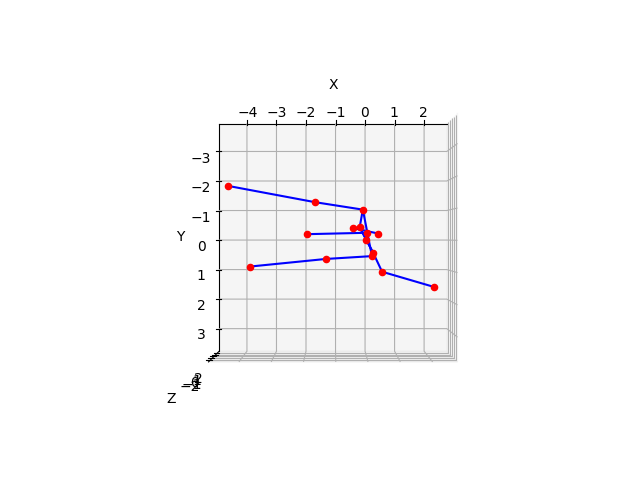

In [118]:
plot_skeleton(coordinates_prime, connections, elev=-90, azim=-90, roll=0)

In [111]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values[0]
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values[0]

left_knee = data[['LeftKneeX', 'LeftKneeY', 'LeftKneeZ']].values[0]
right_knee = data[['RightKneeX', 'RightKneeY', 'RightKneeZ']].values[0]

left_thigh = np.linalg.norm(left_hip - left_knee)
right_thigh = np.linalg.norm(right_hip - right_knee)

s = (left_thigh + right_thigh) / 2

0.18727063220220264

In [113]:
z = coordinates[:, 2]

z_prime = s * np.tanh(z)
z_prime

array([-0.18062296,  0.00959794, -0.03637665, -0.16466725, -0.17482282,
       -0.1870812 , -0.18722389,  0.03870148, -0.03870148,  0.0946161 ,
       -0.06271559,  0.18388769,  0.0933004 , -0.01359527,  0.        ])

In [112]:
z_prime

array([-0.96450231,  0.05125173, -0.19424642, -0.87930097, -0.93353034,
       -0.99898848, -0.9997504 ,  0.20666069, -0.20666069,  0.50523723,
       -0.33489284,  0.98193555,  0.49821159, -0.07259689,  0.        ])

In [117]:
coordinates_prime = np.column_stack((coordinates[:, :2], z_prime))

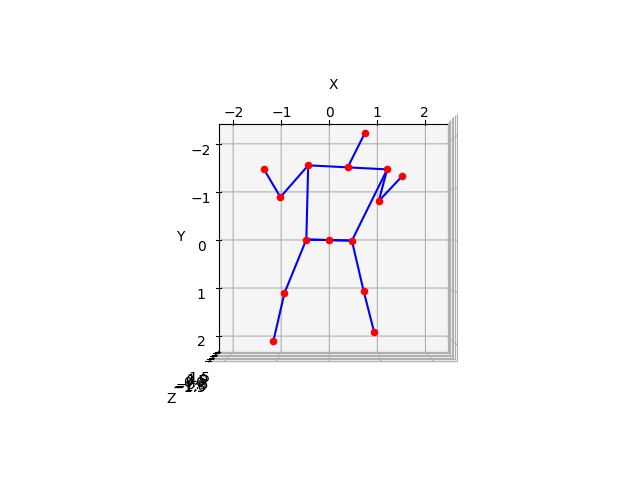

In [118]:
plot_skeleton(coordinates_prime, connections, elev=-90, azim=-90, roll=0)

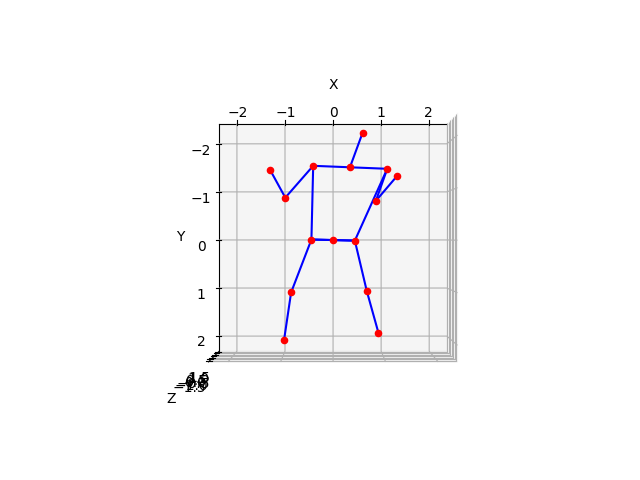

In [120]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values[0]
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values[0]
hip_vector = left_hip - right_hip

angle = np.arctan2(vector[2], vector[0])

rotation_matrix = np.array(
    [
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [- np.sin(angle), 0, np.cos(angle)],
    ]
)

coords_2 = np.dot(rotation_matrix, coordinates_prime.T).T
plot_skeleton(coords_2, connections, elev=-90, azim=-90, roll=0)

In [244]:
left_hip = coords_2[9, :]
right_hip = coords_2[10, :]

right_knee = coords_2[12, :]

# left_hip, right_hip, right_knee

hip_vector = left_hip - right_hip
knee_vector = right_hip - right_knee
hip_vector, knee_vector

(array([0.9895637490533956, 0.052819424933831294, 0.1340660095216066],
       dtype=object),
 array([0.3804562559061971, -0.9609197107699109, -0.18626053554112265],
       dtype=object))

In [247]:
np.rad2deg(calculate(knee_vector, hip_vector))

73.35759264676258

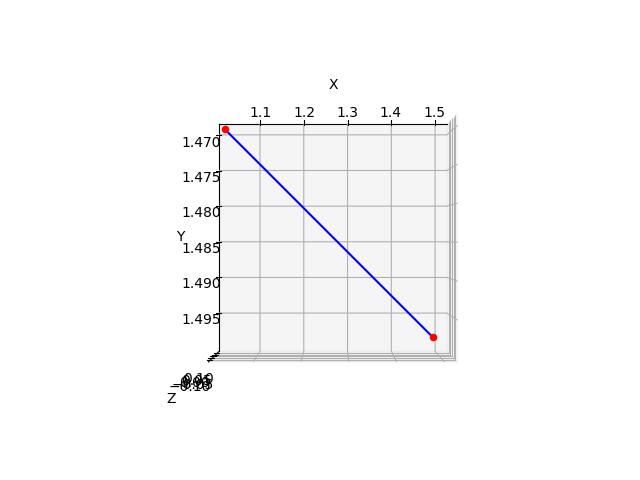

In [119]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values[0]
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values[0]
hip_vector = left_hip - right_hip

subset = 3 * np.array([left_hip, right_hip])
angle = calculate_angle(hip_vector)

plot_skeleton(subset, [(0, 1)], elev=-90, azim=-90, roll=0)

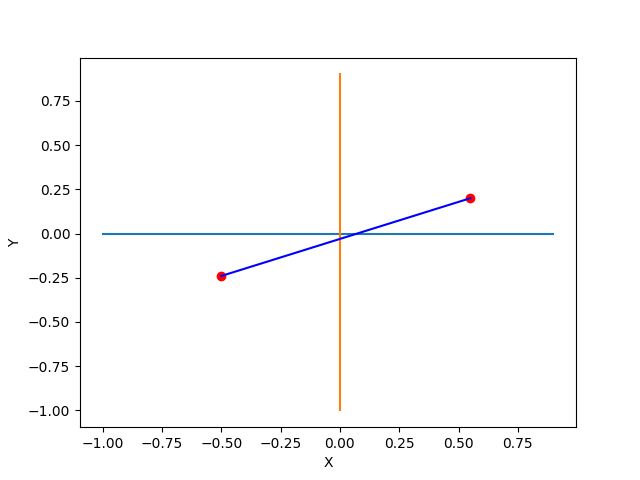

In [276]:
fig = plt.figure()
ax = fig.add_subplot(111)

S = np.arange(-1, 1, 0.1)
plt.plot(S, np.zeros_like(S))
plt.plot(np.zeros_like(S), S)

for joint in subset:
    x, y = joint
    ax.scatter(x, y, c='r', marker='o')

for connection in [(0, 1)]:
    joint_1 = subset[connection[0]]
    joint_2 = subset[connection[1]]
    ax.plot(
        [joint_1[0], joint_2[0]],
        [joint_1[1], joint_2[1]],
        c='b'
    )

# Set axes names
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [285]:
vector = subset[1] - subset[0]
vector

array([1.05, 0.44])

In [286]:
vector[1], vector[0]

(0.44, 1.05)

In [278]:
angle = np.arctan2(vector[1], vector[0])
angle

0.3968181439505531

In [279]:
rotation_matrix = np.array(
    [
        [np.cos(angle), np.sin(angle)],
        [- np.sin(angle), np.cos(angle)],
    ]
)

rotation_matrix
# inverse = np.linalg.inv(rotation_matrix)
# inverse

array([[ 0.9222954 ,  0.38648569],
       [-0.38648569,  0.9222954 ]])

In [280]:
rotated = np.dot(rotation_matrix, subset.T).T
rotated

array([[-0.55390427, -0.02810805],
       [ 0.58455961, -0.02810805]])

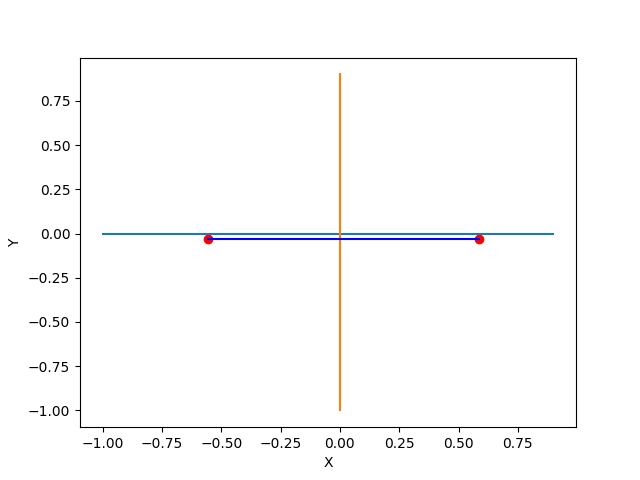

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)

S = np.arange(-1, 1, 0.1)
plt.plot(S, np.zeros_like(S))
plt.plot(np.zeros_like(S), S)

for joint in rotated:
    x, y = joint
    ax.scatter(x, y, c='r', marker='o')

for connection in [(0, 1)]:
    joint_1 = rotated[connection[0]]
    joint_2 = rotated[connection[1]]
    ax.plot(
        [joint_1[0], joint_2[0]],
        [joint_1[1], joint_2[1]],
        c='b'
    )

# Set axes names
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [122]:
def calculate_angle(vector, unit_vector):
    n_vector = vector / np.linalg.norm(vector)

    dot_product = np.dot(n_vector, unit_vector)
    
    cos_alpha = dot_product / np.linalg.norm(n_vector)
    bounded_cos_alpha = min(1, max(-1, cos_alpha))

    return np.rad2deg(np.arccos(bounded_cos_alpha.item()))

In [123]:
left_hip = data[['LeftHipX', 'LeftHipY', 'LeftHipZ']].values
right_hip = data[['RightHipX', 'RightHipY', 'RightHipZ']].values

vector = left_hip - right_hip
vector

angle_x = calculate_angle(vector, np.array([1, 0, 0]))
angle_y = calculate_angle(vector, np.array([0, 1, 0]))
angle_z = calculate_angle(vector, np.array([0, 0, 1]))

In [124]:
angle_x, angle_y, angle_z

(30.66053422969141, 86.9722609165292, 59.521985989151794)

In [130]:
np.rad2deg(np.arctan(1/4))

14.036243467926479

In [134]:
np.rad2deg(np.arccos(3 / np.sqrt(3**2 + 4**2 + 1**2))), np.rad2deg(np.arccos(4 / np.sqrt(3**2 + 4**2 + 1**2))), np.rad2deg(np.arccos(1 / np.sqrt(3**2 + 4**2 + 1**2)))

(53.960106569696144, 38.32881810145588, 78.69006752597979)

In [135]:
np.rad2deg(np.arctan(1 / 4)), np.rad2deg(np.arctan(3 / 1)), np.rad2deg(np.arctan(4 / 3))

(14.036243467926479, 71.56505117707799, 53.13010235415598)

In [126]:
unit_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

dot_products = np.dot(vector, unit_vectors.T)

# Oblicz długości wektorów i wersorów
hip_difference_norm = np.linalg.norm(vector)
unit_vectors_norm = np.linalg.norm(unit_vectors, axis=1)

# Oblicz cosinusy kątów nachylenia
cos_angles = dot_products / (hip_difference_norm * unit_vectors_norm)

# Oblicz kąty nachylenia w radianach
angles = np.arccos(cos_angles)

# Zamień kąty na stopnie, jeśli potrzebujesz
angles_degrees = np.degrees(angles)

angles_degrees


angle_x = np.arctan2(vector[0, 2], vector[0, 1])
angle_y = np.arctan2(vector[0, 0], vector[0, 2])
angle_z = np.arctan2(vector[0, 1], vector[0, 0])

# Zamień kąty na stopnie, jeśli potrzebujesz
angles_degrees = np.degrees([angle_x, angle_y, angle_z])

print("Kąt obrotu względem osi OX:", angles_degrees[0])
print("Kąt obrotu względem osi OY:", angles_degrees[1])
print("Kąt obrotu względem osi OZ:", angles_degrees[2])


TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable arccos method

In [110]:
bounded_cos_alpha[0]

0.8602037334472569

In [97]:
dot_product = np.dot(hip_vector, [1, 0, 0])

cos_alpha = dot_product / (
    np.linalg.norm(hip_vector) * np.linalg.norm([1, 0, 0])
)

bounded_cos_alpha = min(1, max(-1, cos_alpha))

# alpha = np.arccos(bounded_cos_alpha)
# alpha

In [100]:
bounded_cos_alpha[0]

0.8602037334472569

In [102]:
np.rad2deg(np.arccos(bounded_cos_alpha[0]))

30.66053422969141

In [ ]:
def rotation_procedure(self):
    """
    
    """
    # Calculate the dot product of default position vector and hips vector
    dot_product = np.dot(self.default_position, self.hips_vector)

    # Calculate the cosine of default position vector and hips vector
    cos_alpha = dot_product / (
        np.linalg.norm(self.default_position) * np.linalg.norm(self.hips_vector)
        )

    # Protection against numerical errors - cosine value should be in the range [-1, 1]
    bounded_cos_alpha = min(1, max(-1, cos_alpha))

    # Calculate alpha using arccosine function
    alpha = np.arccos(bounded_cos_alpha)

    return alpha
    

def rotate(self, coordinates):
    """
    
    """
    alpha = self.rotation_procedure()

    rotation_matrix = np.array(
        [
            [m.cos(alpha), 0, m.sin(alpha)],
            [0, 1, 0],
            [-m.sin(alpha), 0, m.cos(alpha)],
        ]
    )

    return np.dot(rotation_matrix, coordinates)